# One Integration 6-Body Solar System  

<ul id="top">
    <li><a href="#Loading-packages-and-functions">Loading packages and functions</a></li>
    <li><a href="#Definition-of-the-N-body-problem">Definition of the N-body problem</a></li>
    <li><a href="#Integrations">Integrations</a></li>
    <li><a href="#Summary">Summary</a></li>
    <li><a href="#Errors-in-energy">Errors in energy</a></li>
    <li><a href="#Errors-in-position">Errors in position</a></li>
</ul>

## Loading packages and functions

In [1]:
using LinearAlgebra
using Plots

include("../../src/SplittingMethods.jl")
using .SplittingMethods  ## bertsio lokala exekutatzeko  

##### <a href="#top">Back to the top</a>

## Definition of the N-body problem

In Nbody.jl below, the following functions are defined: NbodyEnergy(u,Gm), NbodyODE!(du,u,Gm,t), and NbodyODE1!(du,u,Gm,t), where

\begin{equation*}
u = 
\left(\begin{matrix}
q_1  & v_1\\
\vdots & \vdots \\
q_N  & v_N
\end{matrix}
\right) \in \mathbb{R}^{2 \times 3\times N}, \quad
Gm = (G\,  m_1, \ldots,G\,  m_N) \in \mathbb{R}^N.
\end{equation*}

The energy, as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\mathrm{Energy}(q_1,\ldots,q_N,v_1,\ldots,v_N) = 
\frac12 \sum_{i=1}^{N} m_i \, \|v_i\|^2
- G \sum_{1\leq i < j \leq N} \frac{m_i m_j}{\|q_i-q_j\|}.
\end{split}
\end{equation*}


The ODE system of the N-body problem,
as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\frac{d}{dt} q_i &= v_i, \\
\frac{d}{dt} v_i &= G\, 
\sum_{j \neq i} \frac{m_j}{\|q_j-q_i\|^3}\,
(q_j-q_i).
\end{split}
\end{equation*}
This system of ODEs can be writen in compact form as
\begin{equation*}
\frac{d u}{dt} = f(t,u,Gm)
\end{equation*}




In [2]:
PATH_ODES="../../ODEProblems/"

include(string(PATH_ODES,"Initial6Body.jl"))
include(string(PATH_ODES,"Nbody.jl"));

### Initial value problem: 6-body problem (outer solar system)

We consider $N=6$ bodies of the outer solar system: the Sun, Jupiter, Saturn, Uranus, Neptune and Pluto.
The initial values $u_{00}$ are taken from DE430, Julian day (TDB) 2440400.5 (June 28, 1969). 

In [3]:
u0, Gm, bodylist = Initial6Body(Float64)
u0_B=BigFloat.(u0)
Gm_B=BigFloat.(Gm)

q0=u0[:,:,1]
v0=u0[:,:,2]

N = length(Gm)

show(bodylist)
E0=NbodyEnergy(u0,Gm)

["Sun" "Jupiter" "Saturn" "Uranus" "Neptune" "Pluto"]

-9.522620605966966e-12

In [4]:
# Testing: center of mass of the outer solar system at the origin of coordinates with zero velocity

q0_ = zeros(3)
v0_ = zeros(3)
Gm0_ = 0.
for i in 1:6
    Gmi = Gm[i]
    qi = u0[:,i,1]
    vi = u0[:,i,2]
    q0_ += Gmi*qi
    v0_ += Gmi*vi
    Gm0_ += Gmi
end
(q0_/Gm0_, v0_/Gm0_)

([1.417048569677335e-18, 9.119357686204585e-20, 1.5082339679877506e-19], [1.0942040830907497e-22, -2.709864045560887e-22, 1.6237832716049163e-22])

In [5]:
t0=0.
tF=1e7   #1e9  # days

tspan= (t0,tF)
tspan_B=(BigFloat(t0),BigFloat(tF));


In [6]:
Jupiter_period = 11.9*365
tF/Jupiter_period

2302.290779325429

In [7]:
year=365.25
tF/year

27378.507871321013

In [8]:
flows=[flowH1Nbody!, flowH2Nbody!]
prob=SplittingProblem(flows, u0, tspan, Gm);

##### <a href="#top">Back to the top</a>

## Integration

###  Konposizio metodoa (10 ordenekoa) 

In [9]:
dt0=100.

m0 = max(1,div(Int64(ceil((tF-t0)/dt0)),1000))
saveat=m0*dt0

println("dt = $dt0, steps=$((tF-t0)/dt0), m=$m0, n=$(tF/saveat)")

r=10  # SS05 
alg=Splitting_alg(r=10)
@time sol=solver_Splitting(prob, alg, dt=dt0, msteps=m0 )
sol.success

dt = 100.0, steps=100000.0, m=100, n=1000.0
  1.072188 seconds (1.00 M allocations: 50.679 MiB, 63.82% compilation time)


true

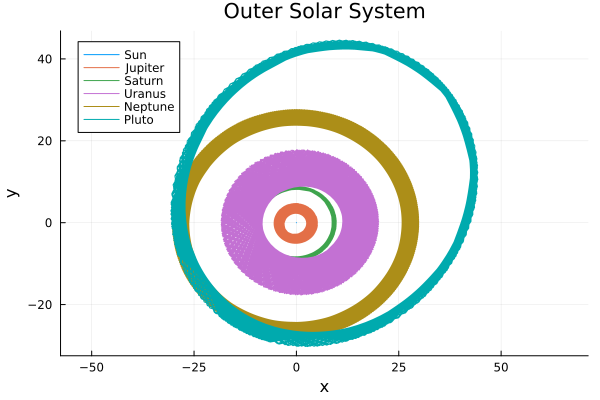

In [10]:
pl = plot(title="Outer Solar System", 
            xlabel="x", ylabel="y",  aspect_ratio=1)

for j = 1:6
    x  = [u[1,j,1] for u in sol.u]
    y  = [u[2,j,1] for u in sol.u] 
    pl = plot!(x,y, label=bodylist[j]) 
end 
display(pl)

### RKN Splitting

In [11]:
dt0=100.

m0 = max(1,div(Int64(ceil((tF-t0)/dt0)),1000))
saveat=m0*dt0

println("dt = $dt0, steps=$((tF-t0)/dt0), m=$m0, n=$(tF/saveat)")

r=8 # BM02 
alg=Splitting_alg(r=8,rkn=true)
@time sol2=solver_Splitting(prob, alg, dt=dt0, msteps=m0)
sol2.success


dt = 100.0, steps=100000.0, m=100, n=1000.0
  0.218567 seconds (2.15 k allocations: 426.618 KiB)


true

<a href="#top">Back to the top</a>

## Errors in energy

In [12]:
function ErrorEnergy(H0, Ham, sol, parms_B)

    H = [Ham(BigFloat.(u),parms_B) for u in sol.u]
    ΔH0 = @. Float64(abs(H/H0-1))
    H_lerr = @. Float64(abs((H[2:end] / H[1:end-1]) - 1))
   
    return ΔH0, H_lerr

end

ErrorEnergy (generic function with 1 method)

In [13]:
u0_B = BigFloat.(u0)
Gm_B = BigFloat.(Gm)
H0=NbodyEnergy(u0_B,Gm_B)

ΔH0, H_lerr=ErrorEnergy(H0, NbodyEnergy, sol, Gm_B)
(maximum(ΔH0), maximum(H_lerr))

(4.0861764157311537e-13, 2.9628216731896295e-14)

In [14]:
ΔH02, H_lerr2=ErrorEnergy(H0, NbodyEnergy, sol2, Gm_B)
(maximum(ΔH02), maximum(H_lerr2))

(2.7958894051090014e-13, 4.7435799462395146e-14)

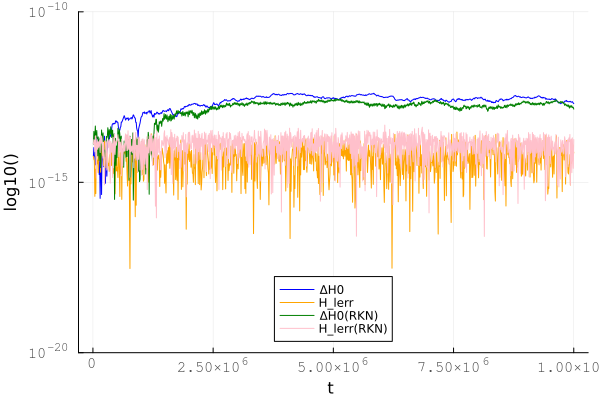

In [15]:
yrange=(1e-20,1e-10)
plot(title="",xlabel="t ", ylabel="log10()", 
     yscale=:log10, ylims=yrange,
     xtickfont = font(8, "Courier"),
     ytickfont = font(8, "Courier"),
     legend=:bottom)
plot!(sol.t,abs.(ΔH0),label="ΔH0", color="blue")
plot!(sol.t[2:end],abs.(H_lerr),label="H_lerr", color="orange")

plot!(sol2.t,abs.(ΔH02),label="ΔH0(RKN)", color="green")
plot!(sol2.t[2:end],abs.(H_lerr2),label="H_lerr(RKN)", color="pink")